In [1]:
from pyabc import History
from pyabc.visualization import plot_kde_matrix, kde_1d
import pyabc.visualization
import scipy.stats as st
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Inferring neonic toxicity from feeding study data and the VarroaPop+Pesticide model

#### 4/19/19 update

## Approximate Bayesian Computation with SMC sampling

We have reanalyzed the model with the following changes:
* 60% pupae -> adult transition to fit control data
* Account for unobserved active foragers
* Now fitting the model to # of eggs in addition to # of adults


#### Defining our analysis and plotting functions first

In [7]:
#retrieve stored run
database_dir = 'results_db/'
db_path = ("sqlite:///" + os.path.join(database_dir, "run_3_11.db"))
history = History(db_path)
history.id = 1
t = history.max_t

In [8]:
## Define convenience functions for characterizing marginal distributions
def get_ci(variable, df, w, interval = 95):
    """
    Extract 95% credible intervals for a single parameter weighted posterior samples
    """
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    lower = (x.item(np.min(np.where(cdf > .025))))
    upper = (x.item(np.min(np.where(cdf > .975))))
    return lower, upper

def get_MAP(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    MAP = x[np.where(np.max(pdf)==pdf)]
    return MAP.item()

def get_mean(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    mean = np.average(x, weights=pdf)
    return mean

def get_sd(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    sd = np.sqrt(np.cov(x, aweights=pdf))
    return sd
    
def get_median(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    median = (x.item(np.min(np.where(cdf > .5))))
    return median

def describe_marginal(variable, df, w, units = None):
    lower, upper = get_ci(variable, df, w)
    sd = get_sd(variable, df, w)
    MAP = get_MAP(variable, df, w)
    mean = get_mean(variable, df, w)
    median = get_median(variable, df, w)
    unit_str = ""
    if units:
        unit_str = units
    print("Descriptive statistics for {}:".format(variable))
    print("Mean: {:.2f} {}".format(mean, unit_str))
    print("SD: {:.2f} {}".format(sd, unit_str))
    print("Median {:.2f} {}".format(median, unit_str))
    print("MAP: {:.2f} {}".format(MAP, unit_str))
    print("95% CI: {:.2f} - {:.2f} {}".format(lower, upper, unit_str))

In [9]:
#define some functions to do our sampling and plotting

def draw_posterior(df, w, n=1):
    indices = df.index
    draws = random.choices(population=indices, weights = w, k=n)
    return df.loc[draws,:]
    
def get_prediction_interval(sample_in, percent=95, max_dose=100, adult=True):
    """
    Get PIs for dose-response curve. 
    Function that takes a set of samples of the posterior (as a input) and returns
    the lower and upper perdiction intervals as 1d arrays.
    """
    sample = sample_in.reset_index(drop=True)
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = np.empty([len(sample.index),x.size])
    if adult:
        for index, row in sample.iterrows():
            ld50 = row[0]
            slope = row[1]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    else:
        for index, row in sample.iterrows():
            ld50 = row[2]
            slope = row[3]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    lower = np.percentile(y,q=(100-percent)/2, axis=0)
    upper = np.percentile(y, q=100-((100-percent)/2), axis=0)
    return lower, upper


def plot_dr_map(df, adult=True, xlim=100, ci=True, percent = 95, sample_num=300, title="Dose-response curve"):
    """
    Plot the dose-response curve for a posterior based on maximum a posteriori values.
    Can also include prediction intervals, which are based on weighted random sampling of the particles. 
    """
    if adult:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AIAdultLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AIAdultSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    else:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AILarvaLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AILarvaSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    sample = draw_posterior(df, w, sample_num)
    lower, upper = get_prediction_interval(sample, max_dose=xlim, adult=adult)
    fix, ax = plt.subplots()
    x = np.linspace(0,xlim, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50_MAP/x)**slope_MAP) #four parameters Hill equation, equal to what VarroaPop uses
    ax.plot(x, y, linewidth=3, label="Max. a posteriori")
    ax.plot(x,lower, 'k', linestyle=":", linewidth=2, label="95% prediction int.")
    ax.plot(x,upper, 'k', linestyle=":", linewidth=2)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    ax.legend()
    plt.show()


#### Dose-response curves for Clothianidin

* Maximum a posteriori = Most probable given the data
* 95% prediction interval = Value will fall within this range 95% of the time

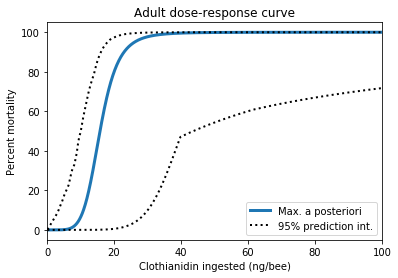

In [10]:
#for adults
df, w = history.get_distribution(m=0, t=t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
random.seed(1251)
plot_dr_map(df, percent=95, xlim=100, title = "Adult dose-response curve")

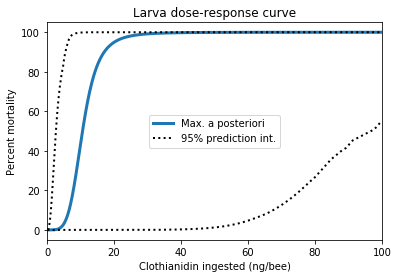

In [11]:
random.seed(1251)
plot_dr_map(df, percent=95, adult=False, title = "Larva dose-response curve")

In [12]:
describe_marginal("AIAdultLD50", df, w, units = "ng/bee")
print()
describe_marginal("AILarvaLD50", df, w, units = "ng/bee")
print()

Descriptive statistics for AIAdultLD50:
Mean: 20.08 ng/bee
SD: 8.08 ng/bee
Median 17.91 ng/bee
MAP: 15.81 ng/bee
95% CI: 9.67 - 40.69 ng/bee

Descriptive statistics for AILarvaLD50:
Mean: 43.11 ng/bee
SD: 28.31 ng/bee
Median 38.56 ng/bee
MAP: 10.59 ng/bee
95% CI: 3.72 - 95.48 ng/bee



#### Now let's make predictions about colony health 

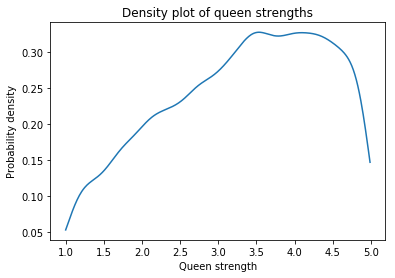

In [13]:
# define some helper functions
def plot_queenstrength(sample_in, mean_col = 6, sd_col = 7, title='Density plot of queen strengths',):
    sample = sample_in.reset_index(drop=True)
    lower = 1
    upper = 5
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .01)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel='Queen strength', ylabel='Probability density', title=title)
    plt.show()

random.seed(1251)
sample = draw_posterior(df,w,200)
plot_queenstrength(sample)
    

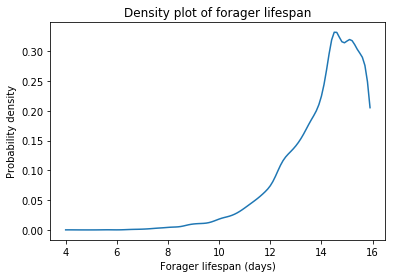

In [14]:
def plot_foragerlifespan(sample_in, mean_col = 4, sd_col=5, title='Density plot of forager lifespan',):
    sample = sample_in.reset_index(drop=True)
    lower = 4
    upper = 16
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .1)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel='Forager lifespan (days)', ylabel='Probability density', title=title)
    plt.show()
    
random.seed(1251)
sample = draw_posterior(df,w,200)
plot_foragerlifespan(sample)

#### I've plotted the fit of our VarroaPop-based model of the feeding study to the actual study data.

#### Guide to the plots:
* The blue line is the prediction based on parameter means
* The dotten lines are the 95% prediction intervals, based on our inferred parameter distributions (posteriors)
* The orange dots with bars are the observed feeding study means and standard deviations

#### Number of adults
![alt text](figures/posterior_predictions/bee_population/run_3_11/Adults.png "Fit to adult population")


#### Number of pupae
![alt text](figures/posterior_predictions/bee_population/run_3_11/Pupae.png "Fit to pupae population")

#### Number of larvae
![alt text](figures/posterior_predictions/bee_population/run_3_11/Larvae.png "Fit to larvae population")

#### Number of eggs
![alt text](figures/posterior_predictions/bee_population/run_3_11/Eggs.png "Fit to egg population")